In [1]:
!python --version

Python 3.10.0


## Imports

In [2]:
import os 
import re
import string
import numpy as np
import spacy as sp
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

c:\Users\mathe\anaconda3\envs\projects-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carregando os dados

In [3]:
dataset_path = 'dataset/'
dataset_name = 'dataset.csv'

dataset = pd.read_csv(os.path.join(dataset_path, dataset_name))
dataset

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo"
...,...,...
516,"Selecione o local de estudo, curso sem encontr...",educação
517,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,"educação,orgão público"
518,Empresas e órgãos públicos,orgão público
519,DGE – Departamento de Gestão Estratégica Metas...,orgão público


## Exploratória

In [4]:
texto = 'sentence'
setor = 'category'

dataset[texto].sample(5).tolist()

['Imagem de Geladeira Refrigerador Frost Free Inox 454L.',
 'Assuntos: Auxílio-Doença Previdenciário, Benefícios em Espécie, DIREITO PREVIDENCIÁRIO Aposentadoria por Invalidez (Art. 42/7).',
 'DGE – Departamento de Gestão Estratégica Metas Nacionais Portal CNJ de Boas Práticas do Poder Judiciário',
 'Escolha a forma de pagamento e depois clique em continuar.',
 'Relações Humanas, carga horária total do módulo 14hs.']

In [5]:
dataset[setor].value_counts()

category
orgão público               140
educação                    107
indústrias                   89
varejo                       85
finanças                     54
finanças,varejo              13
educação,orgão público        9
indústrias,varejo             7
educação,indústrias           5
finanças,orgão público        4
finanças,indústrias           3
indústrias,orgão público      2
educação,finanças             2
varejo,indústrias             1
Name: count, dtype: int64

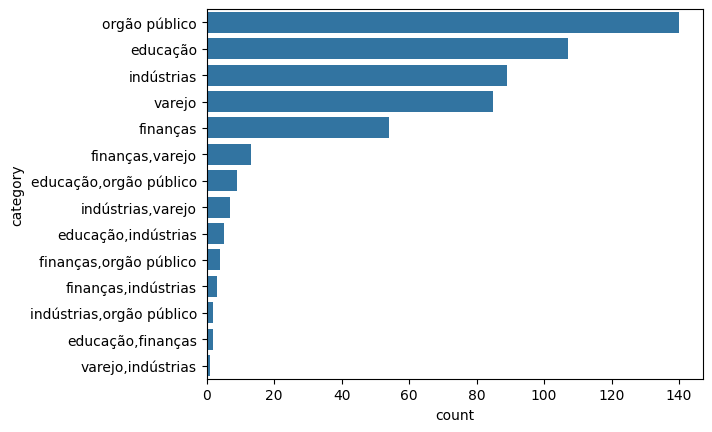

In [6]:
ordenados = dataset[setor].value_counts().index
sns.countplot(dataset[setor], order=ordenados);

Observando a frequência com que os setores são atribuídos aos textos, fica claro que o 'multi-labeling' não é tão presente, ou seja,
existem bem mais textos classificados à apenas um setor. 

Nesse momento, é importante decidir qual será a abordagem da modelagem. A priori, tendo a acreditar que modelar um multi-label não vá ser eficiente dado esse 'desbalanceamento'.

Uma alternativa é associar cada texto à um único setor.
- **E aqueles que são associados a dois setores?**

    Estes serão duplicados e associados aos dois setores. 
    
    Exemplo:
    
     'ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS EM VALPARAÍSO.' -> 'educação'   
     'ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS EM VALPARAÍSO.' -> 'orgão público'

    Assim, quando o modelo receber um input que se referir tanto ao setor 'educação' quanto ao setor 'orgão público', ele tenderá a dar pesos mais altos para essas duas classes. 

- **O modelo não vai ficar confuso tendo duas labels para o mesmo texto?**

    Essa abordagem de fato pode atrapalhar o aprendizado do modelo e diminuir a acurácia, no entanto, parte-se do pressuposto de que o modelo tenderá a atribuir maiores pesos para os textos relacionados à um setor em específico.

## Duplicando os textos com mais de um setor atribuído


In [7]:
## A label com dois setor está assumindo o tipo 'string' única, precisamos fazer com que seja uma lista com duas strings
dataset[setor] = [set.split(',') for set in dataset[setor]]
dataset

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",[orgão público]
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",[finanças]
2,Então encontraremos na próxima aula.,[educação]
3,Veja os resultados da categoria de ofertas do ...,[indústrias]
4,"Além disso, a embalagem é reutilizável e 100% ...","[indústrias, varejo]"
...,...,...
516,"Selecione o local de estudo, curso sem encontr...",[educação]
517,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,"[educação, orgão público]"
518,Empresas e órgãos públicos,[orgão público]
519,DGE – Departamento de Gestão Estratégica Metas...,[orgão público]


In [8]:
## Duplicando as linhas e reiniciando o index
dataset = dataset.explode(setor).reset_index(drop=True)
dataset

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...",indústrias
...,...,...
562,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,educação
563,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,orgão público
564,Empresas e órgãos públicos,orgão público
565,DGE – Departamento de Gestão Estratégica Metas...,orgão público


## Tratamento dos textos

Uma vez com o dataset de textos e labels, é necessário fazer o tratamento dos textos para tornar o aprendizado do modelo mais eficiente. Para isso, é comum fazer a remoção de caracteres especiais e pontuações, assim como a  realização da tokenização (processo que divide o texto em unidades menores [palavras ou subpalavras]). Além disso, tambem devemos converter o texto para letras minúsculas para garantir consistência na contagem de palavras.

- Remover a acentuação.
- Remover caracteres especiais.
- Remover as 'stop words' que são palavras normalmente encaradas como 'ruído' no texto. 

Isso é importante para reduzirmos a dimensão de features e facilitar a identificação de padrões mais relevantes.

In [9]:
## Definindo stop words 
nlp = sp.blank("pt")
stop_words = sp.lang.pt.STOP_WORDS
[sw for sw in stop_words][:10]

['sempre',
 'tentaram',
 'veja',
 'saber',
 'disso',
 'agora',
 'apontar',
 'dez',
 'nossa',
 'somos']

In [10]:
## Caracteres especiais
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
## Usando re (Regular Expression)
exemplo = 'Ele gosta de caçar'
re.sub(r"[ç]", "c", exemplo)  #Removendo o 'ç'

'Ele gosta de cacar'

In [12]:
def cleaning(text):
    text = text.lower()

    text = re.sub(r"[!@#%&$*º“”—-]", "", text)
    text = re.sub(r"[àáâãäåã]", "a", text)
    text = re.sub(r"[èéêë]", "e", text)
    text = re.sub(r"[ìíîï]", "i", text)
    text = re.sub(r"[òóôõö]", "o", text)
    text = re.sub(r"[ùúûü]", "u", text)
    text = re.sub(r"[ýÿ]", "y", text)
    text = re.sub(r"[ç]", "c", text)

    text = text.lower()
    document = nlp(text)

    words = []
    for token in document:
        words.append(token.text)

    words = [word for word in words if word not in stop_words and word not in string.punctuation] 
    words = ' '.join([str(element) for element in words])

    return words

In [13]:
## Comparando texto original com o texto processado
for text in dataset[texto].sample(5).tolist():
    print(text)
    print(cleaning(text))
    print('\n')

Além disso, a embalagem é reutilizável e 100% reciclável.
alem embalagem reutilizavel 100 reciclavel


Cláusula anticorrupção - Instrução Normativa Conjunta CGE/SEA Nº 01/2020
clausula anticorrupcao   instrucao normativa conjunta cge sea n 01/2020


Valor Boleto R$ 888,00 no cartão de crédito em até  10X R$ 88,80. 
boleto r 888,00 cartao credito ate    10x r 88,80


Juntada de certidão - requisição de pagamento preparada para transmissão.
juntada certidao   requisicao pagamento preparada transmissao


Mensagem da Nissan do Brasil: Compre seu carro 0 km hoje mesmo!
mensagem nissan brasil compre carro 0 km hoje




In [14]:
dataset[texto] = [cleaning(text) for text in dataset[texto]]
dataset[setor] = [cleaning(text) for text in dataset[setor]]

dataset

,sentence,category
0,auxiliodoenca previdenciario beneficios especi...,orgao publico
1,"pagar contas atraso r1.290,90",financas
2,entao encontraremos proxima aula,educacao
3,resultados categoria ofertas modelo nissan kicks,industrias
4,alem embalagem reutilizavel 100 reciclavel,industrias
...,...,...
562,estudantes rede municipal voltam aulas valparaiso,educacao
563,estudantes rede municipal voltam aulas valparaiso,orgao publico
564,empresas orgaos publicos,orgao publico
565,dge – departamento gestao estrategica metas na...,orgao publico


#### Tokenização

Antes da tokenização, vamos definir X como os textos e y sendo a representação númerica de cada setor (aplicando o label enconding)

In [15]:
X = dataset[texto]

enc = LabelEncoder()
y = enc.fit_transform(dataset[setor])

In [16]:
print('X >>\n',X[:5])
print('-----')
print('y >>',y[:5])

X >>
 0    auxiliodoenca previdenciario beneficios especi...
1                        pagar contas atraso r1.290,90
2                     entao encontraremos proxima aula
3     resultados categoria ofertas modelo nissan kicks
4           alem embalagem reutilizavel 100 reciclavel
Name: sentence, dtype: object
-----
y >> [3 1 0 2 2]


In [17]:
## Construindo o tokenizer (tendo 10 mil como o tamanho do vocabulario alvo)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(X, target_vocab_size=10000)

In [18]:
## Tamanho do vocabulário
tokenizer.vocab_size

2341

In [19]:
tokenizer.subwords[:5]

['   ', 'r_', 'carro_', 'voce_', 'sao_']

Exemplo de como funciona a tokenização:

In [20]:
ids = tokenizer.encode('Aprenda LIBRAS')
ids

[2150, 2197, 135, 2161, 2158, 2151, 2167, 2150, 2168]

In [21]:
text = tokenizer.decode(ids)
text

'Aprenda LIBRAS'

___

In [22]:
data_inputs = [tokenizer.encode(sentence) for sentence in X]
data_inputs[:5]

[[639, 232, 117, 106, 31, 142],
 [93, 284, 1877, 86, 2131, 688, 2129, 120],
 [564, 1554, 140, 641],
 [220, 618, 28, 1203, 7, 1279],
 [119, 166, 133, 42, 401]]

#### Padding

Uma vez que muitos modelos exigem que o dado de entrada sejam de uma dimensão em específico, vamos aplicar o padding para que todos os inputs sejam do mesmo tamanho. 

In [23]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=50)

In [24]:
data_inputs[:2]

array([[ 639,  232,  117,  106,   31,  142,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  93,  284, 1877,   86, 2131,  688, 2129,  120,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]])

## Modelagem

Como um primeiro modelo, optei criar uma Rede Neural Convolucional (CNN) que receberá os textos no formato `data_inputs`. Essa CNN processará o texto ao longo de camadas de convolução e pooling e, por fim, retornará a probabilidade do texto de entrada estar associado a cada classe possível.

Primeiro é necessário separar os dados de treino e os dados de teste.

In [25]:
data_labels = np.array(y)
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.1,
                                                                        stratify = data_labels)

In [26]:
print('Shape dos dados de treinamento:',f'Inputs: {train_inputs.shape} Labels: {train_labels.shape}')
print('Shape dos dados de teste:',f'Inputs: {test_inputs.shape} Labels: {test_labels.shape}')

Shape dos dados de treinamento: Inputs: (510, 50) Labels: (510,)
Shape dos dados de teste: Inputs: (57, 50) Labels: (57,)


In [27]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=False,
               name='dcnn'):

    ## Inicializando modelo
    super(DCNN, self).__init__(name=name)

    ## Primeira camada (Embeddings)
    self.embedding = layers.Embedding(vocab_size, emb_dim)

    ## Segunda camada (Kernels)
    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')
    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    ## Terceira camanda (Pooling)
    self.pool = layers.GlobalMaxPool1D()
    # self.batchnorm = layers.BatchNormalization()

    ## A saída da camada pooling, já é uma camada flatten

    ## Rede densa
    self.dense_1 = layers.Dense(units=ffn_units, activation='relu')
    self.dropout = layers.Dropout(rate=dropout_rate)

    if nb_classes == 2:
      self.last_dense = layers.Dense(units=1, activation='sigmoid')
    else:
      self.last_dense = layers.Dense(units=nb_classes,activation='softmax')

  def call(self, inputs, training):
    # Função de chamada que define o passo de propagação para frente do modelo

    # Camada de embeddings: converte os índices de palavras em vetores de embedding
    x = self.embedding(inputs)

    # Convolução de bigrama seguida por pooling
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)

    # Convolução de trigrama seguida por pooling
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)

    # Concatenando as saídas das convoluções de bigrama e trigrama
    merged = tf.concat([x_1, x_2], axis=-1) 
    merged = self.dense_1(merged) # processa a concatenação das saídas das camadas de pooling
    merged = self.dropout(merged, training=training) # dropout para evitar overfitting
    output = self.last_dense(merged) #ultima camada
   
    return output